# <span style = "color : blue"> Gensim word vector visualization of various word vectors </span>

In [1]:
import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

> ### CS224N 강의와 동일한 GloVe 100 Dimension word vector를 사용하겠습니다. <br>
> ### 파일은 이 링크를 통해 다운받을 수 있습니다. [주의! 822MB](https://nlp.stanford.edu/data/glove.6B.zip)

In [5]:
# GloVe 파일 가상환경에 업로드 (shape = (400000, 100))

glove_file = datapath('/data/nlp_study/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

C:\Users\user\AppData\Local\Temp\ipykernel_14024\856280968.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


(400000, 100)

In [6]:
#model 정의

model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [7]:
# input string과 가장 유사한 단어와 유사도를 출력합니다.

model.most_similar('obama')

[('barack', 0.937216579914093),
 ('bush', 0.9272855520248413),
 ('clinton', 0.896000325679779),
 ('mccain', 0.8875634074211121),
 ('gore', 0.8000320196151733),
 ('hillary', 0.7933663129806519),
 ('dole', 0.7851963639259338),
 ('rodham', 0.7518897652626038),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472624182701111)]

In [8]:
# positive 리스트에 있는 항목에 가산점을 부여합니다.
# negative 리스트에 있는 항목에 감점을 부여합니다.

result = model.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.7699


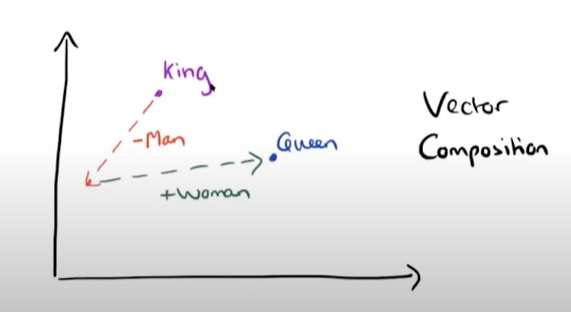

In [9]:
# 단어벡터를 벡터공간에 표시한 후, 2차원 공간으로 PCA를 진행한 그래프를 출력하는 함수입니다.

def display_pca_scatterplot(model, words = None, sample=0):
    
    #words 리스트에 항목이 없으면 단어벡터에서 랜덤하게 추가합니다.
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])
    
    # 다차원의 단어벡터를 2차원으로 축소합니다.
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    # 그래프로 나타내기
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

<IPython.core.display.Javascript object>


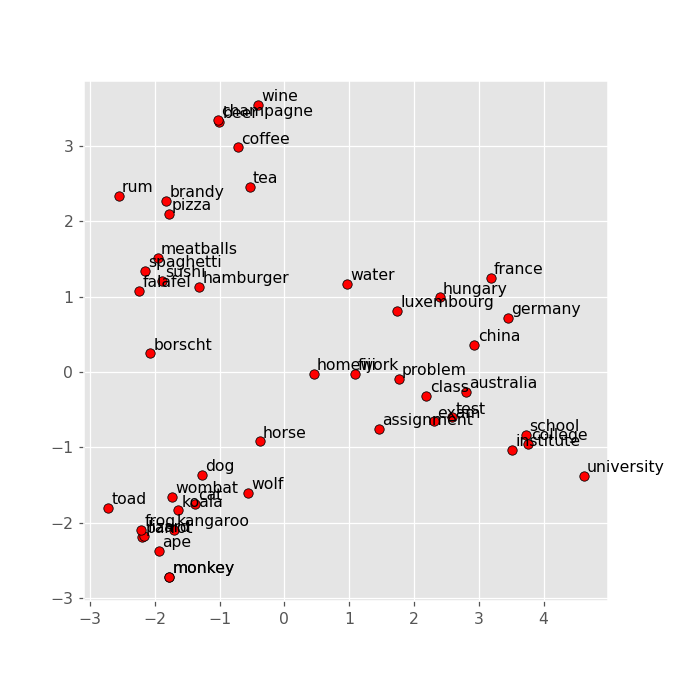

In [10]:
display_pca_scatterplot(model, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

# <span style = "color : blue"> 네이버 영화리뷰 데이터로 한국어 word2vec 학습하기 </span>

깃허브 폴더에서 네이버 영화리뷰 파일을 받아온 후, 강의와 동일하게 한국어 데이터셋으로 단어간 유사도를 조사하는 작업을 진행하겠습니다.

In [20]:
#prerequisites

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm

In [13]:
# Retrieve Data from githubcontents

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x22ddb0fa550>)

In [14]:
train_data = pd.read_table('ratings.txt')

In [15]:
# 결측치 제거

train_data = train_data.dropna(how = 'any')

In [16]:
# 한글이 아닌 단어들을 정규 표현식을 통해 제거합니다.

train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\user\AppData\Local\Temp\ipykernel_14024\2876022004.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [19]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (CPU 기준 7분 정도 소요됩니다!)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [07:47<00:00, 427.86it/s]


In [22]:
# Word2Vec 모델 받아온 후 model로 정의

from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [33]:
# 모델을 저장하고, 가상환경으로 저장한 모델을 불러옵니다.

model.wv.save_word2vec_format('model_w2v')
loaded_model = KeyedVectors.load_word2vec_format("model_w2v")

In [36]:
# 벡터공간의 크기 확인

loaded_model.vectors.shape

(16477, 100)

## <span style = "color : skyblue"> word2vec으로 간단한 영화 추천시스템 제작 </span>

In [47]:
# 좋아하는 영화 장르와 싫어하는 영화장르를 입력하면 5가지 키워드를 출력하는 간단한 함수를 만들어보았습니다.

p = str(input("좋아하는 영화 키워드를 작성해주세요 (,로 구분): "))
p = [_.strip() for _ in p.split(',')]

n = str(input("싫어하는 영화 키워드를 작성해주세요 (,로 구분): "))
n = [_.strip() for _ in n.split(',')]

def movie_rec(pref_p, pref_n):
    return loaded_model.most_similar(positive = pref_p, negative = pref_n, topn = 5)

movie_rec(p, n)

좋아하는 영화 키워드를 작성해주세요 (,로 구분): 로맨스, 판타지
싫어하는 영화 키워드를 작성해주세요 (,로 구분): 멜로, 블록버스터


[('사랑', 0.5285388231277466),
 ('얘기', 0.5279046893119812),
 ('일상', 0.5090022087097168),
 ('순수하다', 0.5059464573860168),
 ('이야기', 0.49493521451950073)]

## 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding)

3.3GB 크기의 사전에 훈련된 영어 모델입니다. 영어로된 데이터를 word2vec으로 학습할 일이 생긴다면 다운받은 후 파인튜닝 하시면 되겠습니다.

```python
import gensim
import urllib.request

urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
```
